In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix, accuracy_score, classification_report, recall_score
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import umap.umap_ as umap
import matplotlib
from sklearn.manifold import Isomap
from os.path import join
import os

from sklearn.neighbors import NearestNeighbors
import pickle
from sklearn.metrics import pairwise_distances


/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv('chimefrbcat1.csv')

df['repeater_name'].value_counts()

repeater_name
-9999           506
FRB20180916B     33
FRB20180814A     20
FRB20190208A      5
FRB20181128A      4
FRB20190222A      3
FRB20181119A      3
FRB20190212A      3
FRB20190303A      3
FRB20121102A      3
FRB20180908B      2
FRB20190117A      2
FRB20190116B      2
FRB20181017A      2
FRB20181030A      2
FRB20190213A      2
FRB20190209A      2
FRB20190604A      2
FRB20190417A      1
Name: count, dtype: int64

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
        
set_seed(42)

## New model

1. Filter into repeater/non-repeater labels
2. Write model for new data
3. Train/optimize using k=3 CV split
4. Perform analysis on CHIME data
5. Possibly subsample top-n=2 repeaters

In [5]:
class SupervisedVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.3, activation=nn.LeakyReLU(0.1)):
        super(SupervisedVAE, self).__init__()

        self.activation = activation

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),  # Additional dense layer
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate)
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),  # Additional dense layer
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)
        )

        # Classification head for binary classification - tune hyperparameters
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),  # Added extra linear layer
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 4, 1),
        )


    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        class_prob = self.classifier(mu)
        return recon_x, mu, logvar, class_prob




In [6]:
def loss_function(recon_x, x, mu, logvar, class_prob, labels, beta, gamma, class_weight, classification_multiplier):
    reconstruction_loss_fn = nn.MSELoss(reduction='sum')
    pos_weight = torch.tensor([class_weight], dtype=torch.float32, device=device)
    classification_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # check this loss function
    recon_loss = reconstruction_loss_fn(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    class_loss = classification_multiplier * classification_loss_fn(class_prob, labels.unsqueeze(1).float())
    total_loss = recon_loss + beta * kl_loss + gamma * class_loss
    return total_loss, recon_loss, kl_loss, class_loss

In [7]:
frb_data = pd.read_csv('chimefrbcat1.csv')

frb_data.head()

def is_repeater(repeater_name):
    return 1 if repeater_name != "-9999" else 0

# Create a new column 'repeater' based on 'repeater_name', if repeater_name is not -9999, set to 1, else 0
frb_data['repeater'] = frb_data['repeater_name'].apply(is_repeater)

print(frb_data.columns)

frb_data['repeater'].value_counts()

frb_data.head(15)

Index(['tns_name', 'previous_name', 'repeater_name', 'ra', 'ra_err',
       'ra_notes', 'dec', 'dec_err', 'dec_notes', 'gl', 'gb', 'exp_up',
       'exp_up_err', 'exp_up_notes', 'exp_low', 'exp_low_err', 'exp_low_notes',
       'bonsai_snr', 'bonsai_dm', 'low_ft_68', 'up_ft_68', 'low_ft_95',
       'up_ft_95', 'snr_fitb', 'dm_fitb', 'dm_fitb_err', 'dm_exc_ne2001',
       'dm_exc_ymw16', 'bc_width', 'scat_time', 'scat_time_err', 'flux',
       'flux_err', 'flux_notes', 'fluence', 'fluence_err', 'fluence_notes',
       'sub_num', 'mjd_400', 'mjd_400_err', 'mjd_inf', 'mjd_inf_err',
       'width_fitb', 'width_fitb_err', 'sp_idx', 'sp_idx_err', 'sp_run',
       'sp_run_err', 'high_freq', 'low_freq', 'peak_freq', 'chi_sq', 'dof',
       'flag_frac', 'excluded_flag', 'repeater'],
      dtype='object')


,tns_name,previous_name,repeater_name,ra,ra_err,ra_notes,dec,dec_err,dec_notes,gl,...,sp_run,sp_run_err,high_freq,low_freq,peak_freq,chi_sq,dof,flag_frac,excluded_flag,repeater
0,FRB20180725A,180725.J0613+67,-9999,93.42,0.039,-9999,67.07,0.210,-9999,147.29,...,-45.80,4.20,760.1,485.3,607.4,371857.954,371481,0.403,1,0
1,FRB20180727A,180727.J1311+26,-9999,197.72,0.130,-9999,26.42,0.260,-9999,24.76,...,-9.20,3.00,800.2,400.2,493.3,382969.318,381818,0.387,1,0
2,FRB20180729A,180729.J1316+55,-9999,199.40,0.120,-9999,55.58,0.084,-9999,115.26,...,-30.21,0.38,692.7,400.2,525.6,264732.041,186953,0.399,1,0
3,FRB20180729B,180729.J0558+56,-9999,89.93,0.270,-9999,56.50,0.240,-9999,156.90,...,-14.60,3.50,800.2,441.8,657.5,425139.488,421337,0.323,1,0
4,FRB20180730A,180730.J0353+87,-9999,57.39,0.032,-9999,87.19,0.200,-9999,125.11,...,-11.31,0.48,759.2,400.2,483.5,429165.844,417689,0.329,1,0
5,FRB20180801A,180801.J2130+72,-9999,322.53,0.059,-9999,72.72,0.220,-9999,109.21,...,-75.50,5.70,709.3,500.2,595.6,804325.253,800121,0.357,1,0
6,FRB20180806A,180806.J1515+75,-9999,228.56,0.071,-9999,75.62,0.390,-9999,112.27,...,-0.10,1.60,800.2,400.2,665.3,370874.518,369658,0.406,1,0
7,FRB20180810A,180810.J0646+34,-9999,101.47,0.130,-9999,34.86,0.240,-9999,180.67,...,-1.70,1.90,800.2,400.2,552.9,356074.278,356889,0.427,1,0
8,FRB20180810B,180810.J1159+83,-9999,180.41,0.016,-9999,83.14,0.160,-9999,124.71,...,-4.06,0.71,778.6,400.2,400.2,191482.920,183305,0.411,1,0
9,FRB20180812A,180812.J0112+80,-9999,19.33,0.270,-9999,80.78,0.280,-9999,124.02,...,-8.30,3.60,586.4,400.2,400.2,563105.450,560873,0.399,1,0


In [8]:
frb_data['tns_name'].value_counts().head(20)

tns_name
FRB20190122C    6
FRB20181028A    5
FRB20190208A    4
FRB20181222A    4
FRB20190519B    4
FRB20181226B    3
FRB20190604F    3
FRB20180917A    3
FRB20181119D    3
FRB20190605B    3
FRB20181125A    3
FRB20190625E    3
FRB20190422A    3
FRB20190111A    3
FRB20190609A    2
FRB20180814B    2
FRB20190611A    2
FRB20190601C    2
FRB20190527A    2
FRB20190519A    2
Name: count, dtype: int64

In [9]:
frb_data["mjd_400"] = pd.to_numeric(frb_data["mjd_400"], errors="coerce")

# choose the precision that defines sameness
PREC = 6  # use 3 if that is what is needed

frb_data["mjd_400_r"] = frb_data["mjd_400"].round(PREC)


# round MJD to the nearest 3 decimal places
mask = frb_data["repeater"] == 0
frb_data = pd.concat([
    frb_data[mask].drop_duplicates(subset=["tns_name", "mjd_400_r"], keep="first"),
    frb_data[~mask]
])

frb_data = frb_data.sort_index()

frb_data[frb_data['tns_name']=='FRB20190122C'][['mjd_400_r', 'repeater']].values

len(frb_data)

570

In [10]:
labels = frb_data['repeater']

base_features = ['bonsai_dm', 'dm_exc_ne2001', 'dm_exc_ymw16', 'bc_width', 'high_freq', 'low_freq', 'peak_freq']
error_features = ['dm_fitb', 'fluence', 'flux', 'sp_idx', 'sp_run']

all_features = base_features + error_features

for feature in all_features:
    # convert to integer if the feature is not already an integer
    if not pd.api.types.is_integer_dtype(frb_data[feature]):
        frb_data[feature] = pd.to_numeric(frb_data[feature]).astype(int)


for feature in error_features:
    frb_data[f"{feature}_lower"] = frb_data[feature] - frb_data[f'{feature}_err']
    frb_data[f"{feature}_upper"] = frb_data[feature] + frb_data[f'{feature}_err']
    

new_features = [f"{feature}_lower" for feature in error_features] + [f"{feature}_upper" for feature in error_features] + base_features


print(new_features)

frb_data[new_features + ['repeater']].head(15)

['dm_fitb_lower', 'fluence_lower', 'flux_lower', 'sp_idx_lower', 'sp_run_lower', 'dm_fitb_upper', 'fluence_upper', 'flux_upper', 'sp_idx_upper', 'sp_run_upper', 'bonsai_dm', 'dm_exc_ne2001', 'dm_exc_ymw16', 'bc_width', 'high_freq', 'low_freq', 'peak_freq']


,dm_fitb_lower,fluence_lower,flux_lower,sp_idx_lower,sp_run_lower,dm_fitb_upper,fluence_upper,flux_upper,sp_idx_upper,sp_run_upper,bonsai_dm,dm_exc_ne2001,dm_exc_ymw16,bc_width,high_freq,low_freq,peak_freq,repeater
0,714.99590,1.70,0.00,34.30,-49.20,715.00410,6.30,2.00,41.70,-40.80,716,644,635,0,760,485,607,0
1,641.98500,1.24,-0.31,1.20,-12.00,642.01500,2.76,0.31,4.80,-6.00,642,620,622,0,800,400,493,0
2,108.99969,7.00,4.20,15.76,-30.38,109.00031,27.00,17.80,16.24,-29.62,108,78,86,0,692,400,525,0
3,316.99550,0.26,-0.59,10.50,-17.50,317.00450,1.74,0.59,17.50,-10.50,318,223,198,0,800,441,657,0
4,847.99820,15.00,2.20,3.70,-11.48,848.00180,39.00,7.80,4.30,-10.52,849,789,790,0,759,400,483,0
5,654.98400,2.20,0.35,55.20,-80.70,655.01600,11.80,1.65,64.80,-69.30,656,565,547,0,709,500,595,0
6,738.99200,0.40,-0.80,-1.20,-1.60,739.00800,13.60,2.80,1.20,1.60,739,699,706,0,800,400,665,0
7,413.99600,0.00,0.14,-0.50,-2.90,414.00400,2.00,1.86,2.50,0.90,415,310,274,0,800,400,552,0
8,168.99830,4.90,3.70,-0.40,-4.71,169.00170,9.10,6.30,0.40,-3.29,169,123,129,0,778,400,400,0
9,801.96500,2.20,-0.58,-3.40,-11.60,802.03500,7.80,0.58,-0.60,-4.40,795,722,708,0,586,400,400,0


In [11]:
frb_data_clean = frb_data[new_features].dropna()
scaler = StandardScaler()
frb_data_scaled = scaler.fit_transform(frb_data_clean)

In [12]:
indices = frb_data_clean.index

In [13]:
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

full_dataset = ConcatDataset([train_dataset, val_dataset])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
input_dim = val_tensor.shape[1]
hidden_dim = 256
latent_dim = 10
stop_patience = 8
num_epochs = 150

In [15]:
def evaluate_classifier(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='weighted')

    
    false_positives = np.sum((all_labels == 0) & (all_preds == 1))

    return accuracy, class_report, conf_matrix, recall, false_positives  # Return F1 score as well

def get_activation_function(name):
    if name == 'ReLU':
        return nn.ReLU()
    elif name == 'LeakyReLU':
        return nn.LeakyReLU(0.1)
    elif name == 'ELU':
        return nn.ELU()
    elif name == 'SELU':
        return nn.SELU()
    elif name == 'GELU':
        return nn.GELU()
    else:
        raise ValueError(f"Unknown activation function: {name}")

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
import sklearn.metrics

def evaluate_classifier_full(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = sklearn.metrics.f1_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return accuracy, class_report, conf_matrix, all_preds, all_labels

In [17]:
best_params = {'hidden_dim': 1444, 'latent_dim': 16, 'beta': 1.8730554103241046, 'gamma': 1.4481280485077974, 'dropout_rate': 0.10689151034257464, 'lr': 0.00011237260931706744, 'scheduler_patience': 7, 'class_weight': 0.8571344632996859, 'activation': 'ReLU', 'classification_multiplier': 12455.804301750832}
lr = best_params["lr"]
scheduler_patience = best_params["scheduler_patience"]
num_epochs = 150

In [18]:
def train_supervised(model, optimizer, scheduler, epoch, beta, gamma, class_weight, classification_multiplier):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, class_logits = model(data)
        
        # Supervised loss function
        loss, recon_loss, kl_loss, classification_loss = loss_function(
            recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
        )
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        classification_loss_total += classification_loss.item()
        
        predicted = (torch.sigmoid(class_logits) > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
        
        if batch_idx % 100 == 0:
            print(classification_loss)
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_total / len(train_loader.dataset)
    avg_kl = kl_loss_total / len(train_loader.dataset)
    avg_class = classification_loss_total / len(train_loader.dataset)
    accuracy = correct / total
    
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
          f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def validate_supervised(model, scheduler, optimizer, epoch, beta, gamma, class_weight, classification_multiplier):
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            recon_batch, mu, logvar, class_logits = model(data)
            
            loss, recon_loss, kl_loss, classification_loss = loss_function(
                recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
            )
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
            classification_loss_total += classification_loss.item()
            
            predicted = (torch.sigmoid(class_logits) > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = val_loss / len(val_loader.dataset)
    avg_recon = recon_loss_total / len(val_loader.dataset)
    avg_kl = kl_loss_total / len(val_loader.dataset)
    avg_class = classification_loss_total / len(val_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Validation loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy


def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False



In [19]:
garcia_list = '''
FRB20180907E
FRB20180920B
FRB20180928A
FRB20181017B
FRB20181022E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181214A
FRB20181220A
FRB20181226E
FRB20181229B
FRB20190112A
FRB20190128C
FRB20190206B
FRB20190206A
FRB20190218B
FRB20190223A
FRB20190308C
FRB20190308C
FRB20190323D
FRB20190329A
FRB20190410A
FRB20190412B
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190527A
FRB20190527A
FRB20190601C
FRB20190601C
FRB20190617B
FRB20180910A
FRB20190210C
FRB20200726D
'''.split()

luo_list = '''
FRB20181229B
FRB20190423B
FRB20190410A
FRB20181017B
FRB20181128C
FRB20190422A
FRB20190409B
FRB20190329A
FRB20190423B
FRB20190206A
FRB20190128C
FRB20190106A
FRB20190129A
FRB20181030E
FRB20190527A
FRB20190218B
FRB20190609A
FRB20190412B
FRB20190125B
FRB20181231B
FRB20181221A
FRB20190112A
FRB20190125A
FRB20181218C
FRB20190429B
FRB20190109B
FRB20190206B
'''.split()

zhu_ge_list = '''
FRB20180911A
FRB20180915B
FRB20180920B
FRB20180923A
FRB20180923C
FRB20180928A
FRB20181013E
FRB20181017B
FRB20181030E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181130A
FRB20181214A
FRB20181220A
FRB20181221A
FRB20181226E
FRB20181229B
FRB20181231B
FRB20190106B
FRB20190109B
FRB20190110C
FRB20190111A
FRB20190112A
FRB20190129A
FRB20190204A
FRB20190206A
FRB20190218B
FRB20190220A
FRB20190221A
FRB20190222B
FRB20190223A
FRB20190228A
FRB20190308C
FRB20190308C
FRB20190308B
FRB20190308B
FRB20190323D
FRB20190329A
FRB20190403E
FRB20190409B
FRB20190410A
FRB20190412B
FRB20190418A
FRB20190419A
FRB20190422A
FRB20190422A
FRB20190423A
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190517C
FRB20190527A
FRB20190527A
FRB20190531C
FRB20190601B
FRB20190601C
FRB20190601C
FRB20190609A
FRB20190617A
FRB20190617B
FRB20190618A
FRB20190625A
'''.split()

In [20]:
full_model = SupervisedVAE(
        input_dim,
        best_params["hidden_dim"],
        best_params["latent_dim"],
        best_params["dropout_rate"],
        get_activation_function(best_params["activation"])
    ).to(device)

full_model.load_state_dict(torch.load("optimization/saves/trial_332/model_fold_2.pth"))

<All keys matched successfully>

In [21]:
global_font_size = 26
global_figsize = (10, 6)  

In [22]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)



matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'font.size':           global_font_size,
    # Titles, labels, ticks, legends all at 12 pt
    'axes.titlesize':      global_font_size,
    'axes.labelsize':      global_font_size,
    'xtick.labelsize':     global_font_size,
    'ytick.labelsize':     global_font_size,
    'legend.fontsize':     0.82 * global_font_size,
    'figure.titlesize':    global_font_size,
    # ensure a LaTeX package for scalable fonts
    'text.latex.preamble': r'\usepackage{lmodern}'
})


def get_latent_representations(model, dataloader, device):
    model.eval()
    latent_representations = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latent_representations.append(mu.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(latent_representations), np.concatenate(all_labels)


def natural_keys(text):
    """Helper to sort text alphanumerically."""
    return [int(c) if c.isdigit() else c.lower() for c in re.split(r'(\d+)', text)]


def visualize_latent_space_pca(latent_representations, labels,
                               title='PCA of Latent Space Representations',
                               file_path='figs', loc='upper right', palette='tab10', label_pos = (0.05, 0.95)):
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)
    scaler = StandardScaler()
    latent_2d = scaler.fit_transform(latent_2d)

    fig, ax = plt.subplots(figsize=global_figsize)
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1],
                    hue=labels, palette=palette,
                    s=60, alpha=0.8, ax=ax)

    # ax.set_title(title)
    ax.set_xlabel('PCA Dimension 1')
    ax.set_ylabel('PCA Dimension 2')

    handles, labels_ = ax.get_legend_handles_labels()
    if 'Class' in labels_:
        handles, labels_ = handles[1:], labels_[1:]

    sorted_pairs = sorted(zip(labels_, handles), key=lambda x: natural_keys(x[0]))
    labels_, handles = zip(*sorted_pairs)

    ax.legend(handles, labels_, 
              
            borderpad=0.2,
            # reduce space between entries
            labelspacing=0.2,
            loc=loc,
            # shorten the length of the legend lines
            handlelength=1,
            # reduce space between handle and text
            handletextpad=0.3,
            borderaxespad=0.5,
          )

    ax.text(label_pos[0], label_pos[1], 'Latent Space \n PCA', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.75)
    if not os.path.exists(file_path):
        os.makedirs(file_path)
    
    fig.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')),
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)

    plt.show()


def cluster_and_visualize(latent_representations, labels,
                          title='Clusters in PCA-Transformed Latent Space',
                          file_path='figs'):
    latent_2d = PCA(n_components=2).fit_transform(latent_representations)

    n_clusters = len(np.unique(labels))
    cluster_labels = KMeans(n_clusters=n_clusters, random_state=42) \
                     .fit_predict(latent_2d)

    fig, ax = plt.subplots(figsize=global_figsize)
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1],
                    hue=cluster_labels, palette='viridis',
                    s=60, alpha=0.8, ax=ax)

    ax.set_title(title)
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')

    handles, labels_ = ax.get_legend_handles_labels()
    if 'Class' in labels_:
        handles, labels_ = handles[1:], labels_[1:]

    sorted_pairs = sorted(zip(labels_, handles), key=lambda x: natural_keys(x[0]))
    labels_, handles = zip(*sorted_pairs)

    ax.legend(handles, labels_,
              title='Class',
            )

    plt.tight_layout()
    fig.subplots_adjust(right=0.75)
    if not os.path.exists(file_path):
        os.makedirs(file_path)
    
    fig.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')),
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)

    plt.show()

    print(f"Silhouette Score: {silhouette_score(latent_2d, cluster_labels)}")
    print(f"Adjusted Rand Index (ARI): {adjusted_rand_score(labels, cluster_labels)}")



def visualize_latent_space_tsne(latent_representations, labels,
                               title='t-SNE of Latent Space Representations',
                               palette='tab20', file_path='figs', loc='upper right', n_col = 1, many_classes=False, label_pos = (0.05, 0.95), hide_legend=False):
    latent_2d = TSNE(n_components=2, random_state=42) \
                .fit_transform(latent_representations)
                
                
    scaler = StandardScaler()
    latent_2d = scaler.fit_transform(latent_2d)
    

    fig, ax = plt.subplots(figsize=global_figsize)
    scatter = sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1],
                              hue=labels, palette=palette,
                              s=60, alpha=0.8, ax=ax)

    # ax.set_title(title)
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    
    # set x limit to 5

    if many_classes:
        bottom_range_x = np.min(latent_2d[:, 0]) - 0.5
        top_range_x = np.max(latent_2d[:, 0]) + 1.8
        ax.set_xlim(bottom_range_x, top_range_x)

    # Sort legend alphanumerically
    handles, labels_ = ax.get_legend_handles_labels()
    if 'Class' in labels_:
        handles, labels_ = handles[1:], labels_[1:]

    sorted_pairs = sorted(zip(labels_, handles), key=lambda x: natural_keys(x[0]))
    labels_, handles = zip(*sorted_pairs)
    
    ax.legend(handles, labels_,
              borderpad=0.2,
              # reduce space between entries
              labelspacing=0.1,
              columnspacing=0.1,
              loc=loc,
            # shorten the length of the legend lines
            handlelength=1,
            # reduce space between handle and text
            handletextpad=0.3,
            borderaxespad=0.5,
            ncols = n_col,
          )
        
    if hide_legend:
        ax.legend_.remove()
        
    ax.text(label_pos[0], label_pos[1], 'Latent Space \n t-SNE', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.75)

    
    print("hi")
    fig.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')),
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)

    plt.show()




def visualize_latent_space_umap(latent_representations, labels,
                                title="UMAP of Latent Space Representations",
                                palette='tab20', file_path='figs', loc='upper right', many_classes=False, label_pos = (0.05, 0.95)):
    latent_2d = umap.UMAP(n_components=2, random_state=42) \
                .fit_transform(latent_representations)
                
    
    scaler = StandardScaler()
    latent_2d = scaler.fit_transform(latent_2d)

    fig, ax = plt.subplots(figsize=global_figsize)
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1],
                    hue=labels, palette=palette,
                    s=60, alpha=0.8, ax=ax)
    


    # ax.set_title(title)
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')

    handles, labels_ = ax.get_legend_handles_labels()
    if 'Class' in labels_:
        handles, labels_ = handles[1:], labels_[1:]

    sorted_pairs = sorted(zip(labels_, handles), key=lambda x: natural_keys(x[0]))
    labels_, handles = zip(*sorted_pairs)

    ax.legend(handles, labels_, 
              
            borderpad=0.2,
            # reduce space between entries
            labelspacing=0.2,
            loc=loc,
            # shorten the length of the legend lines
            handlelength=1,
            # reduce space between handle and text
            handletextpad=0.3,
            borderaxespad=0.5,
          )
    
    if many_classes:
        bottom_range_x = np.min(latent_2d[:, 0]) - 0.5
        top_range_x = np.max(latent_2d[:, 0]) + 1.8
        ax.set_xlim(bottom_range_x, top_range_x)

    plt.tight_layout()
    fig.subplots_adjust(right=0.75)
    
    ax.text(label_pos[0], label_pos[1], 'Latent Space \n UMAP', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
    
    
    # ensure the file path folder exists
    if not os.path.exists(file_path):
        os.makedirs(file_path)
    
    fig.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')),
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)

    plt.show()
    
    


def visualize_latent_space_isomap(latent_representations, labels,
                                  title="Isomap of Latent Space Representations",
                                  palette='tab20', file_path='figs', loc='upper right', label_pos = (0.05, 0.95)):
    latent_2d = Isomap(n_components=2).fit_transform(latent_representations)
    
    scaler = StandardScaler()
    latent_2d = scaler.fit_transform(latent_2d)

    fig, ax = plt.subplots(figsize=global_figsize)
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1],
                    hue=labels, palette=palette,
                    s=60, alpha=0.8, ax=ax)
    


    # ax.set_title(title)
    ax.set_xlabel('Isomap Dimension 1')
    ax.set_ylabel('Isomap Dimension 2')

    handles, labels_ = ax.get_legend_handles_labels()
    if 'Class' in labels_:
        handles, labels_ = handles[1:], labels_[1:]

    sorted_pairs = sorted(zip(labels_, handles), key=lambda x: natural_keys(x[0]))
    labels_, handles = zip(*sorted_pairs)

    ax.legend(handles, labels_, 
              
            borderpad=0.2,
            # reduce space between entries
            labelspacing=0.2,
            loc=loc,
            # shorten the length of the legend lines
            handlelength=1,
            # reduce space between handle and text
            handletextpad=0.3,
            borderaxespad=0.5,
          )

    plt.tight_layout()
    
    ax.text(label_pos[0], label_pos[1], 'Latent Space \n Isomap', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0
                                                                       , edgecolor='none'))

    fig.subplots_adjust(right=0.75)

    plt.show()


In [23]:
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

source_data_val = list(frb_data.loc[val_indices, "tns_name"])
source_data_val

source_data_train = list(frb_data.loc[train_indices, "tns_name"])
source_data_full = source_data_train + source_data_val


def get_source_data_freq(data_list, n=20):
    label_counts = Counter(data_list)
    top_labels = [label for label, _ in label_counts.most_common(n)]
    source_data_freq = [label if label in top_labels else 'Other' for label in data_list]

    return source_data_freq


# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)
full_dataset = ConcatDataset([train_dataset, val_dataset])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)


In [24]:
train_latent, train_labels_np = get_latent_representations(full_model, train_loader, device)
val_latent, val_labels_np = get_latent_representations(full_model, val_loader, device)
val_labels_string = np.array(['Repeater' if l == 1 else 'Non-repeater' for l in val_labels_np])
full_data_latent, full_data_labels = get_latent_representations(full_model, full_loader, device)
full_data_labels_string = np.array(['Repeater' if l == 1 else 'Non-repeater' for l in full_data_labels])


In [25]:
top = 0.97
bottom = 0.17
left = 0.03
right = 0.68

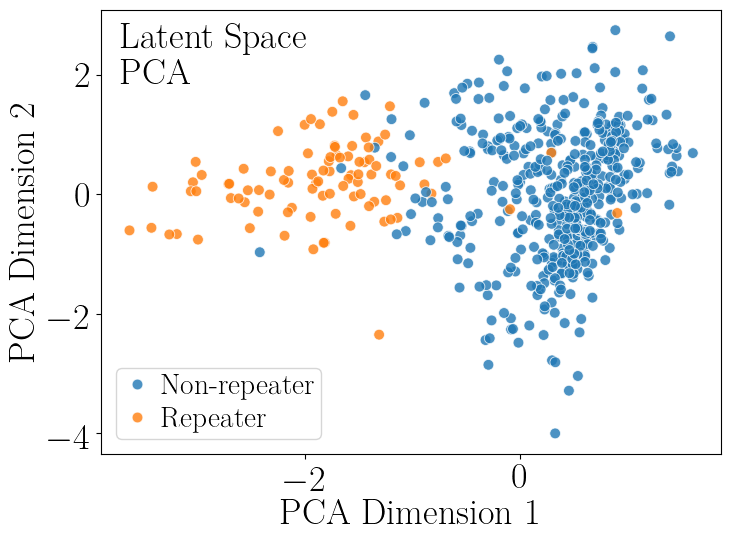

In [26]:
visualize_latent_space_pca(full_data_latent, full_data_labels_string, palette='tab10', file_path='figs/full_dataset', label_pos=(left, top), loc='lower left')

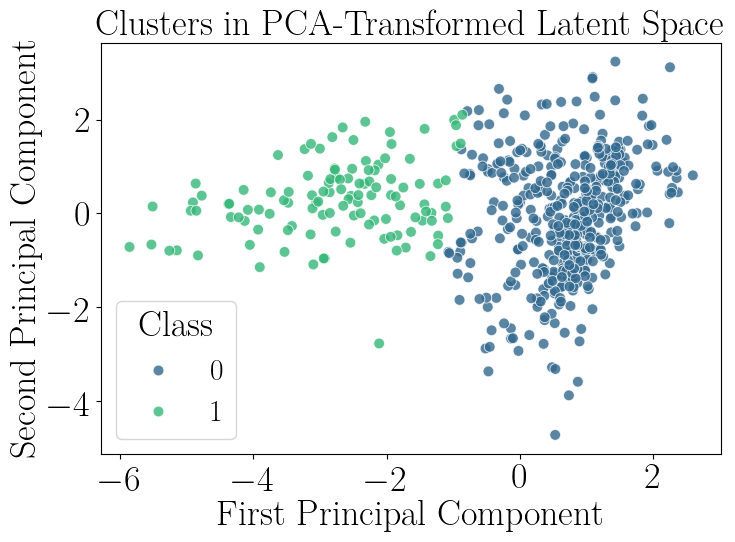

Silhouette Score: 0.5290306806564331
Adjusted Rand Index (ARI): 0.7709544710929929


In [27]:
cluster_and_visualize(full_data_latent, full_data_labels_string, file_path='figs/full_dataset')

hi


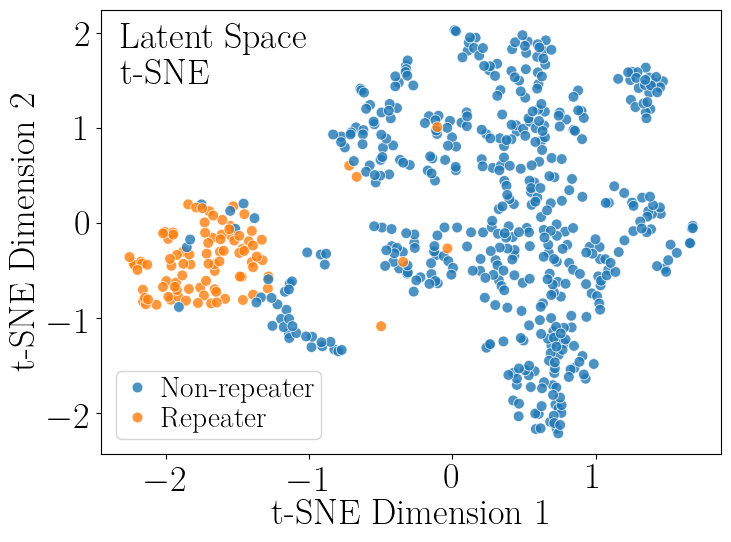

In [28]:
visualize_latent_space_tsne(full_data_latent, full_data_labels_string, palette='tab10', file_path='figs/full_dataset', label_pos=(left, top), loc='lower left')

inspect secondary cluster off of repeater island

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


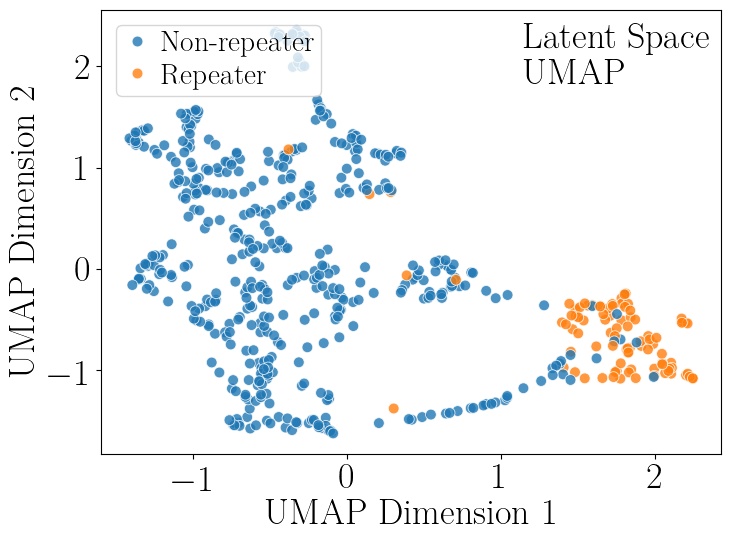

In [29]:
visualize_latent_space_umap(full_data_latent, full_data_labels_string, palette='tab10', file_path='figs/full_dataset', label_pos=(right, top), loc='upper left')

In [30]:
def shortener(source_list, prefix='ID', other_label='Other'):
    """
    Assigns each unique FRB source in source_list an ID string (ID1, ID2, …),
    but if the source equals `other_label`, it stays as-is.
    
    Returns:
        id_map (dict): mapping from FRB signal → ID string (or `Other_label`)
        mapping_df (pd.DataFrame): two‑column table [ID, FRB Signal]
    """
    unique_frbs = pd.unique(source_list)
    
    id_map = {}
    ids, frbs = [], []
    counter = 1
    
    for frb in unique_frbs:
        if frb == other_label:
            id_str = other_label
        else:
            id_str = f"{prefix}{counter}"
            counter += 1
        
        id_map[frb] = id_str
        ids.append(id_str)
        frbs.append(frb)
    
    mapping_df = pd.DataFrame({
        'ID': ids,
        'FRB Signal': frbs
    })
    
    print("ID ↔ FRB Signal mapping:")
    print(mapping_df.to_string(index=False))
    
    return id_map, mapping_df


In [31]:
all_false_positives = ['FRB20181218C',
 'FRB20190122C',
 'FRB20190221A',
 'FRB20190210D',
 'FRB20190320A']


# Get nearest neighbors for each false positive in full dataset latent space

def find_nearest_neighbors(latent_representations, source_names, target_names, k=10):
    # Compute pairwise distances between all points
    distances = pairwise_distances(latent_representations)
    
    # Create a mapping from source names to their indices
    name_to_index = {name: idx for idx, name in enumerate(source_names)}
    
    neighbors_dict = {}
    
    for target in target_names:
        if target not in name_to_index:
            print(f"Warning: {target} not found in source names.")
            continue
        
        target_idx = name_to_index[target]
        
        # Get distances from the target to all other points
        target_distances = distances[target_idx]
        
        # Get indices of the k nearest neighbors (excluding the target itself)
        neighbor_indices = np.argsort(target_distances)[1:k+1]
        
        # Map indices back to names
        neighbors = [source_names[idx] for idx in neighbor_indices]
        
        neighbors_dict[target] = neighbors
    
    return neighbors_dict

false_positive_neighbors = find_nearest_neighbors(
    full_data_latent,
    source_data_full,
    all_false_positives,
    k=50
)

false_positive_neighbors

# for each neighbor of each false positive, check if it's a repeater

for fp, neighbors in false_positive_neighbors.items():
    print(f"False Positive: {fp}")
    for neighbor in neighbors:
        repeater_status = frb_data.loc[frb_data['tns_name'] == neighbor, 'repeater'].values
        status_str = 'Repeater' if repeater_status.size > 0 and repeater_status[0] == 1 else 'Non-repeater'
        print(f"  Neighbor: {neighbor}, Status: {status_str}")
    print()

False Positive: FRB20181218C
  Neighbor: FRB20190329B, Status: Non-repeater
  Neighbor: FRB20190405A, Status: Non-repeater
  Neighbor: FRB20190531A, Status: Non-repeater
  Neighbor: FRB20190323C, Status: Non-repeater
  Neighbor: FRB20190221D, Status: Non-repeater
  Neighbor: FRB20190104A, Status: Non-repeater
  Neighbor: FRB20181022E, Status: Non-repeater
  Neighbor: FRB20190316A, Status: Non-repeater
  Neighbor: FRB20181222E, Status: Non-repeater
  Neighbor: FRB20181222E, Status: Non-repeater
  Neighbor: FRB20181125A, Status: Non-repeater
  Neighbor: FRB20190128D, Status: Non-repeater
  Neighbor: FRB20180921A, Status: Non-repeater
  Neighbor: FRB20190627A, Status: Non-repeater
  Neighbor: FRB20190613B, Status: Non-repeater
  Neighbor: FRB20190203A, Status: Non-repeater
  Neighbor: FRB20190328B, Status: Non-repeater
  Neighbor: FRB20181222B, Status: Non-repeater
  Neighbor: FRB20181215A, Status: Non-repeater
  Neighbor: FRB20181202C, Status: Non-repeater
  Neighbor: FRB20181229B, Statu

In [32]:
# latents
full_latent, full_y = get_latent_representations(full_model, full_loader, device)
Z = pd.DataFrame(full_latent, columns=[f"z{i}" for i in range(full_latent.shape[1])])

# align to original rows in full_dataset order
Y = pd.Series(full_y, name="repeater")

# original features in physical units
X_std = np.vstack([train_data, val_data])                   # same order as full_dataset
X_phys = scaler.inverse_transform(X_std)
X = pd.DataFrame(X_phys, columns=new_features)

df_latent = pd.concat([Z, Y, X.reset_index(drop=True)], axis=1)
df_latent

,z0,z1,z2,z3,z4,z5,z6,z7,z8,z9,...,flux_upper,sp_idx_upper,sp_run_upper,bonsai_dm,dm_exc_ne2001,dm_exc_ymw16,bc_width,high_freq,low_freq,peak_freq
0,0.621582,-0.677051,0.146741,-0.200489,-0.149638,-0.034451,-0.237626,0.251295,0.414404,1.002346,...,0.34,1.40,1.40,211.0,187.0,187.0,0.0,800.0,400.0,400.0
1,-0.385657,1.437154,0.625504,-0.188485,-0.174202,-0.404381,-0.469183,0.220568,-0.819408,1.813648,...,0.25,33.60,-62.00,703.0,539.0,482.0,0.0,528.0,400.0,453.0
2,-0.545293,0.112744,-0.023494,0.300154,-0.425827,-0.117034,0.261887,0.018542,-0.598220,0.331499,...,0.25,28.70,-77.00,420.0,380.0,387.0,0.0,542.0,400.0,461.0
3,0.359980,0.197816,0.506413,-0.032590,0.073130,-0.283522,-0.073891,0.163984,0.259090,0.531542,...,0.35,1.60,-0.50,1020.0,835.0,784.0,0.0,800.0,400.0,457.0
4,1.924215,0.383488,0.436587,-0.972607,1.022644,0.727189,-1.432642,-0.542208,0.898986,0.397468,...,2.71,58.30,-44.20,968.0,942.0,949.0,0.0,800.0,560.0,696.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,0.067448,0.356621,-0.032689,-0.113591,-0.034797,-0.200491,-0.201525,0.106744,-0.335478,1.116683,...,1.52,5.30,-13.30,533.0,511.0,510.0,0.0,671.0,400.0,463.0
566,-1.727733,-0.005508,0.522387,0.865836,0.659724,0.540763,1.011492,-0.104698,-0.155551,-1.584546,...,1.44,53.80,-163.00,349.0,149.0,23.0,0.0,514.0,410.0,459.0
567,-0.398170,0.507761,0.462617,0.294346,0.294392,0.260001,0.126583,-0.013254,-0.315340,0.136869,...,0.26,23.10,-22.10,752.0,692.0,689.0,0.0,707.0,408.0,537.0
568,1.231190,0.269078,0.556301,-0.461737,0.689671,0.568718,-0.873489,-0.392808,0.712250,0.237975,...,1.59,43.30,-33.80,1188.0,1084.0,1050.0,0.0,800.0,515.0,656.0


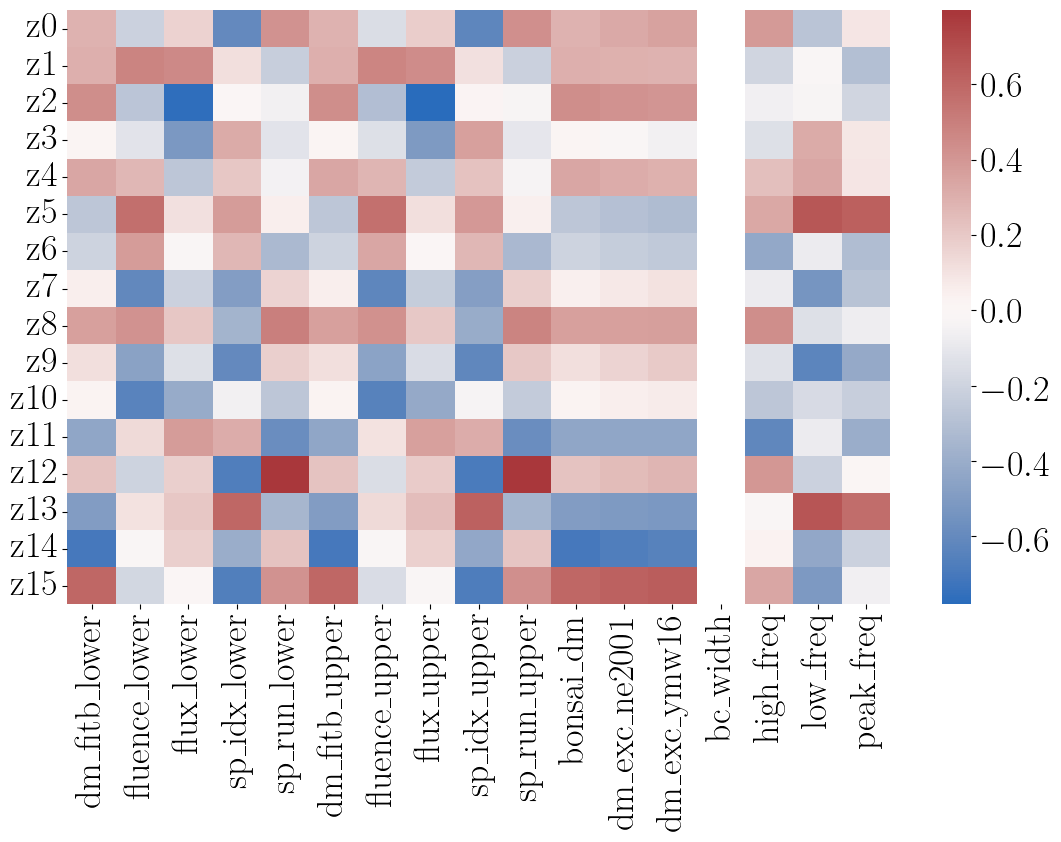

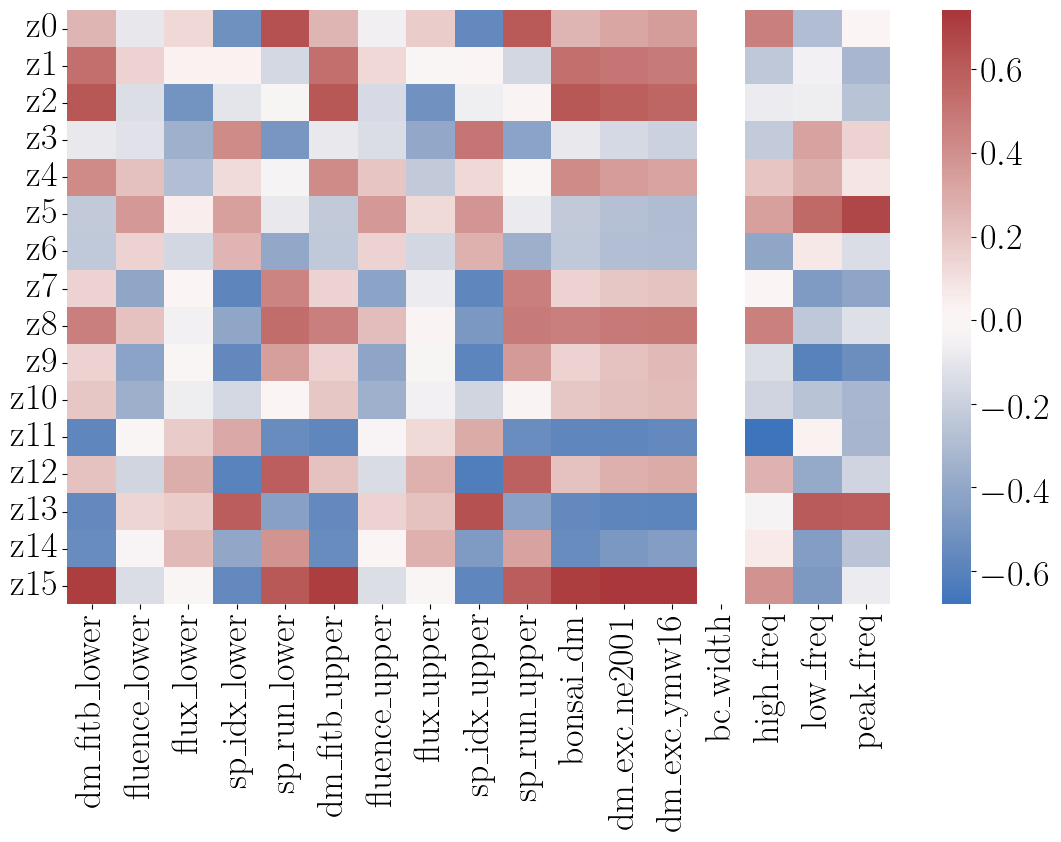

In [33]:
pear = df_latent.corr(method="pearson").loc[Z.columns, X.columns]
spear = df_latent.corr(method="spearman").loc[Z.columns, X.columns]

plt.figure(figsize=(global_figsize[0]*1.5, global_figsize[1]*1.5))
sns.heatmap(pear, cmap="vlag", center=0)

plt.tight_layout()
plt.subplots_adjust(right=0.75)

plt.savefig("figs/full_dataset/Pearson_correlation_z_vs_physical_features.svg",
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1) 

plt.show()

plt.figure(figsize=(global_figsize[0]*1.5, global_figsize[1]*1.5))
sns.heatmap(spear, cmap="vlag", center=0)
plt.tight_layout()


plt.subplots_adjust(right=0.75)

plt.savefig("figs/full_dataset/Spearman_correlation_z_vs_physical_features.svg",
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1) 


plt.show()


do stat test with PCA and UMAP transformed features

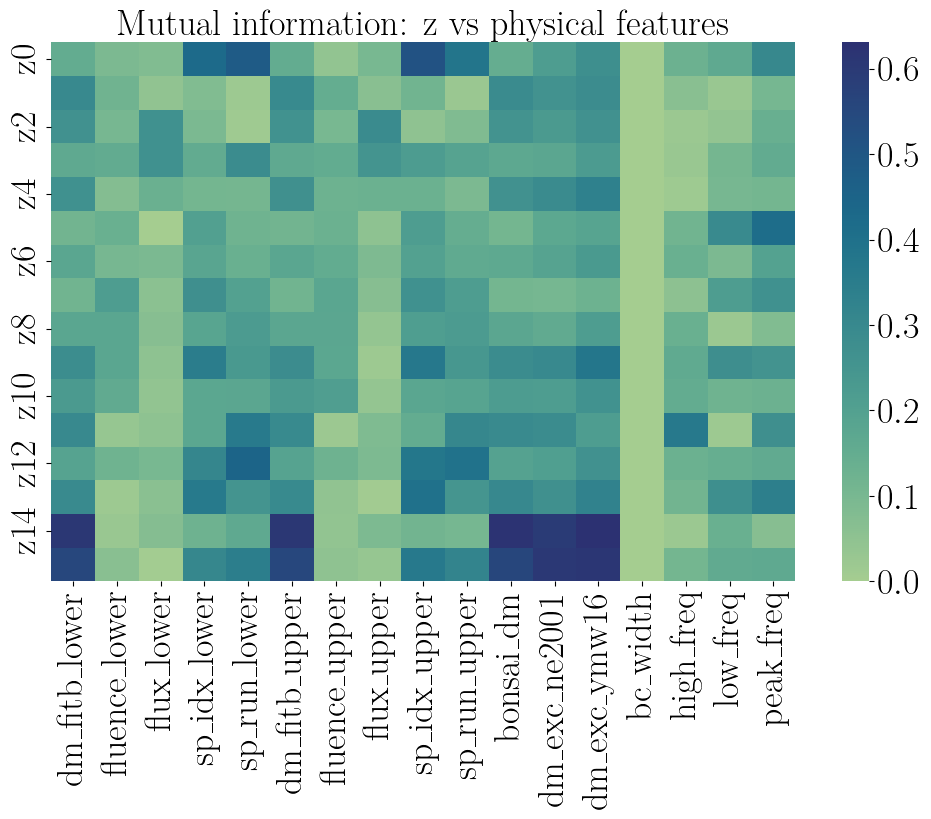

,dm_fitb_lower,fluence_lower,flux_lower,sp_idx_lower,sp_run_lower,dm_fitb_upper,fluence_upper,flux_upper,sp_idx_upper,sp_run_upper,bonsai_dm,dm_exc_ne2001,dm_exc_ymw16,bc_width,high_freq,low_freq,peak_freq
z0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.512524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
z1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
z2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
z3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
z4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
z5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
z6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
z7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
z8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
z9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
from sklearn.feature_selection import mutual_info_regression
mi = pd.DataFrame(index=Z.columns, columns=X.columns, dtype=float)
for feat in X.columns:
    mi[feat] = mutual_info_regression(Z.values, X[feat].values, random_state=0)
mi = mi.fillna(0.0)

plt.figure(figsize=(12, 7))
sns.heatmap(mi, cmap="crest")
plt.title("Mutual information: z vs physical features")

plt.savefig("figs/full_dataset/mi_heatmap.svg", dpi=200, format='svg', bbox_inches='tight', pad_inches=0.1)

plt.show()

mi[mi > 0.5]

In [35]:
import re
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_regression

# spearman rho and p
rho_mat = pd.DataFrame(index=Z.columns, columns=X.columns, dtype=float)
p_mat   = pd.DataFrame(index=Z.columns, columns=X.columns, dtype=float)

pairs = []
pvals = []
for zi in Z.columns:
    for feat in X.columns:
        r, p = spearmanr(Z[zi], X[feat], nan_policy="omit")
        rho_mat.loc[zi, feat] = r
        pairs.append((zi, feat))


# mutual information matrix
mi_mat = pd.DataFrame(index=Z.columns, columns=X.columns, dtype=float)
for feat in X.columns:
    mi_mat[feat] = mutual_info_regression(Z.values, X[feat].values, random_state=0)

# build a compact axis table: for each z_i, take top-2 features by |rho| with MI as tie-breaker
rows = []
top_features_by_z = {}
for zi in Z.columns:
    dfz = pd.DataFrame({
        "feature": X.columns,
        "rho": rho_mat.loc[zi].values.astype(float),
        "mi": mi_mat.loc[zi].values.astype(float),
    })
    dfz["abs_rho"] = dfz["rho"].abs()
    
    dfz = dfz.sort_values(["abs_rho"], ascending=[False]).reset_index(drop=True)
    top_features_by_z[zi] = dfz["feature"].tolist()

    top1 = dfz.iloc[0]
    top2 = dfz.iloc[1] if len(dfz) > 1 else None

    rows.append({
        "z": zi,
        "top_feature": top1["feature"],
        "rho": float(top1["rho"]),
        "mi": float(top1["mi"]),
        "runner_up": (top2["feature"] if top2 is not None else None),
        "runner_up_rho": (float(top2["rho"]) if top2 is not None else None),
        "runner_up_mi": (float(top2["mi"]) if top2 is not None else None),
    })

axis_table = pd.DataFrame(rows).sort_values(
    ["z"],
).reset_index(drop=True)

print("Axis labels (suggested):")
display(axis_table[[
    "z","top_feature","rho","mi","runner_up","runner_up_rho", "runner_up_mi"
]])

/tmp/ipykernel_244107/2413446758.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = spearmanr(Z[zi], X[feat], nan_policy="omit")


Axis labels (suggested):


,z,top_feature,rho,mi,runner_up,runner_up_rho,runner_up_mi
0,z0,sp_run_lower,0.642629,0.484784,sp_run_upper,0.612265,0.383560
1,z1,bonsai_dm,0.528797,0.288486,dm_fitb_lower,0.528025,0.298635
2,z10,fluence_lower,-0.362636,0.159332,fluence_upper,-0.353939,0.210535
3,z11,high_freq,-0.679969,0.366809,dm_fitb_upper,-0.570664,0.297298
4,z12,sp_idx_upper,-0.625086,0.374718,sp_idx_lower,-0.600816,0.312602
5,z13,sp_idx_upper,0.644863,0.399647,low_freq,0.603008,0.275797
6,z14,bonsai_dm,-0.545519,0.621498,dm_fitb_lower,-0.544510,0.609090
7,z15,dm_exc_ymw16,0.741782,0.611483,dm_exc_ne2001,0.736178,0.604976
8,z2,dm_fitb_upper,0.624375,0.263188,bonsai_dm,0.624176,0.258398
9,z3,sp_idx_upper,0.501892,0.219823,sp_run_lower,-0.493116,0.286431


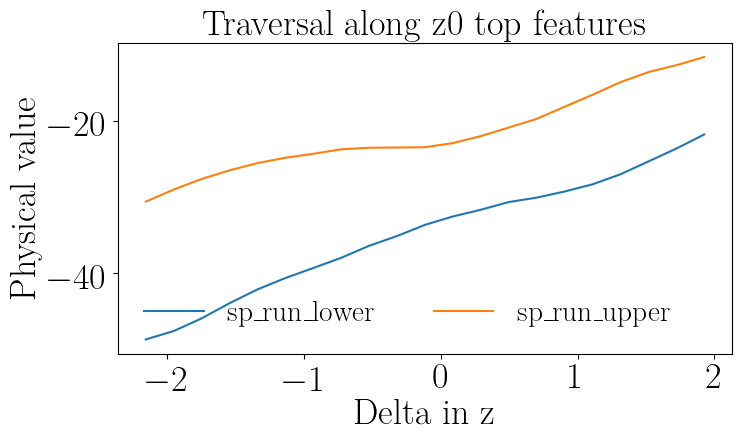

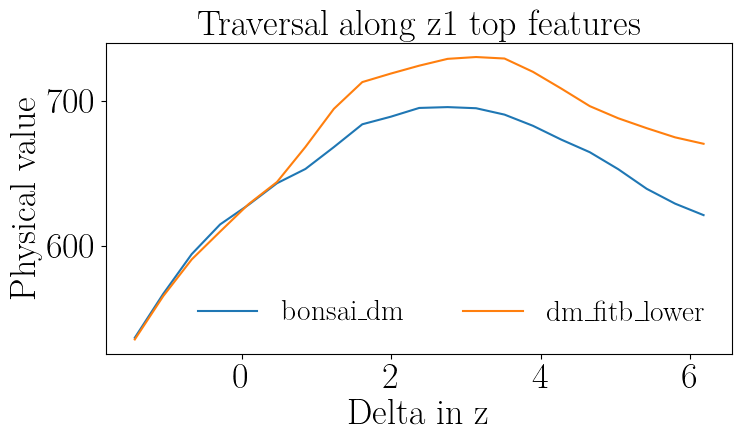

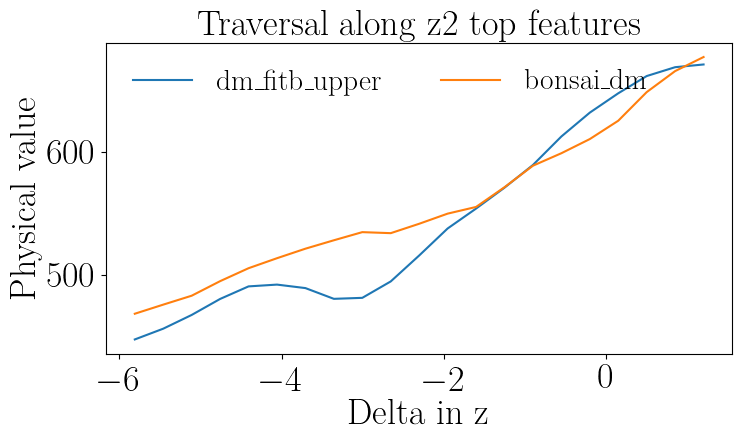

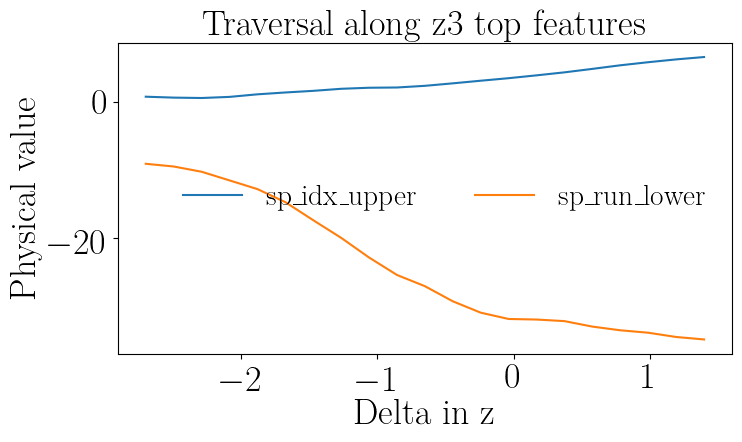

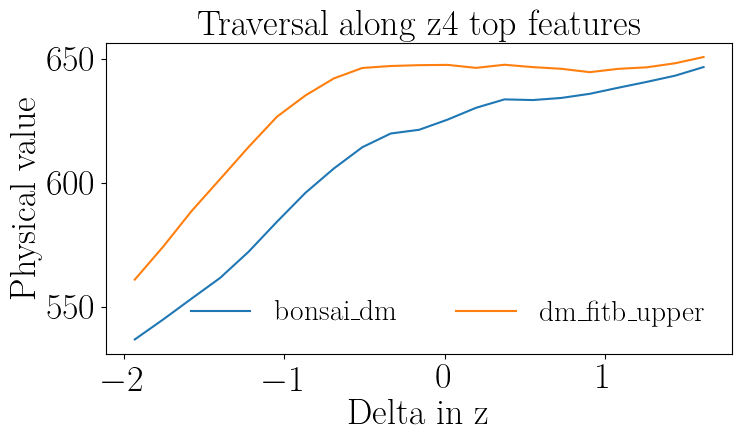

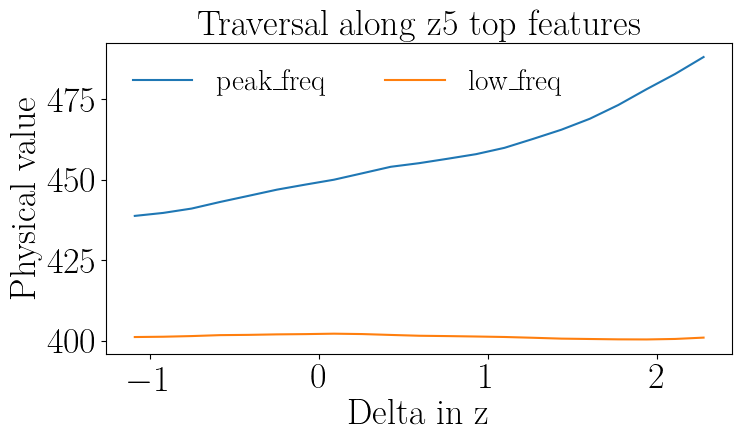

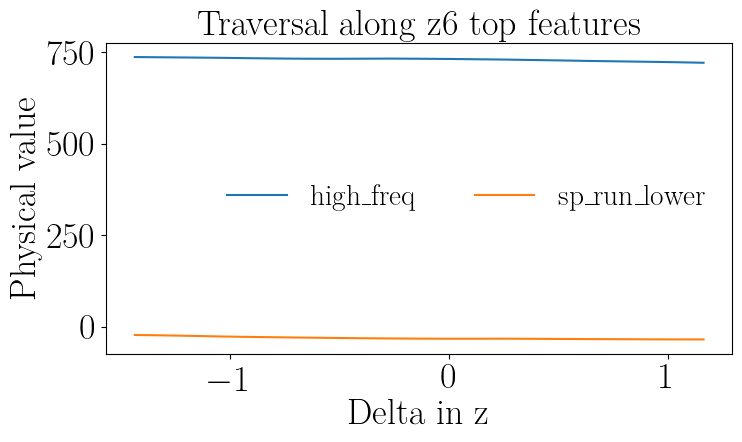

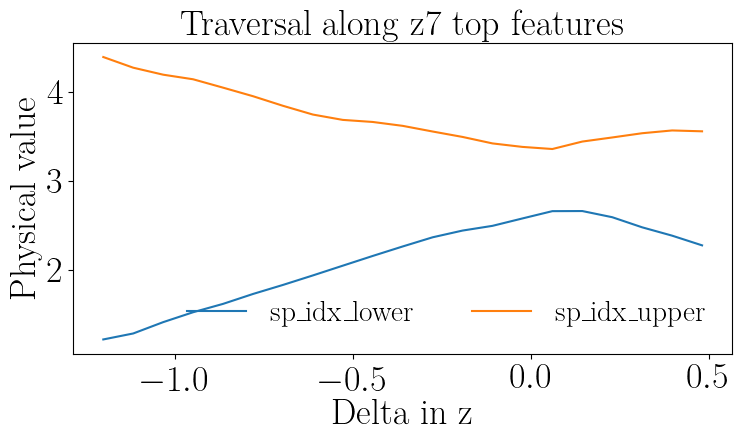

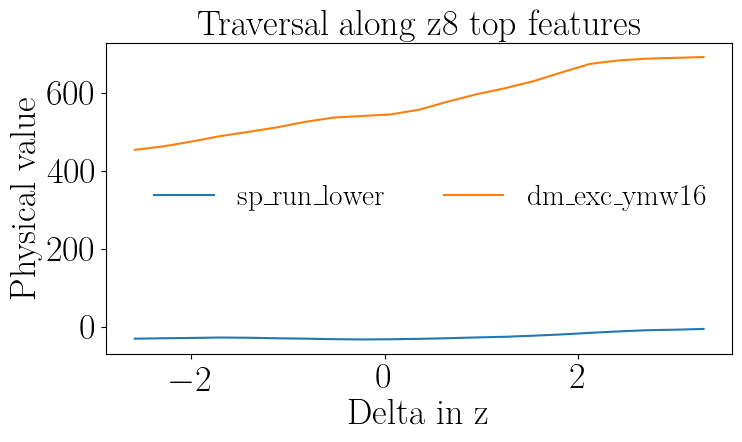

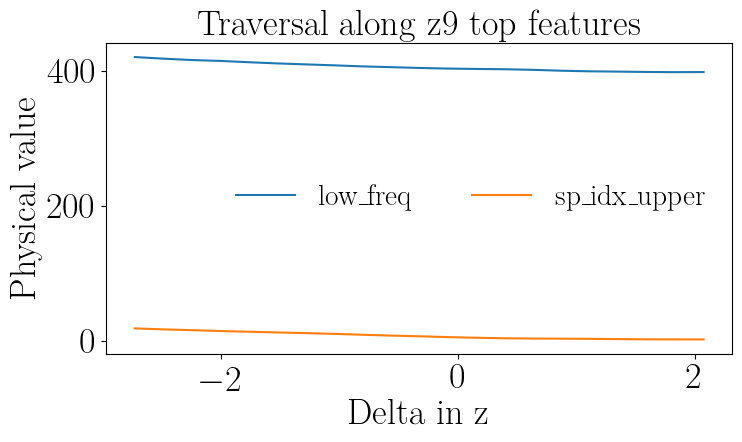

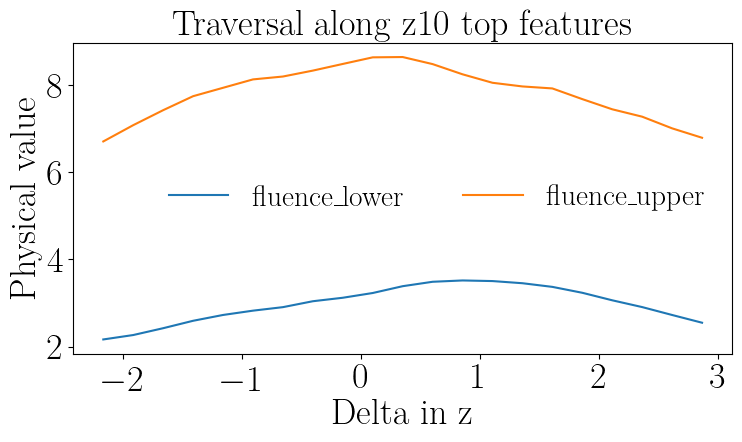

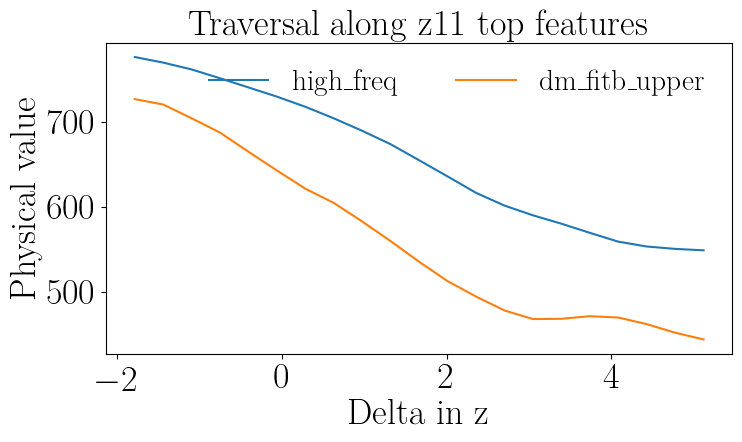

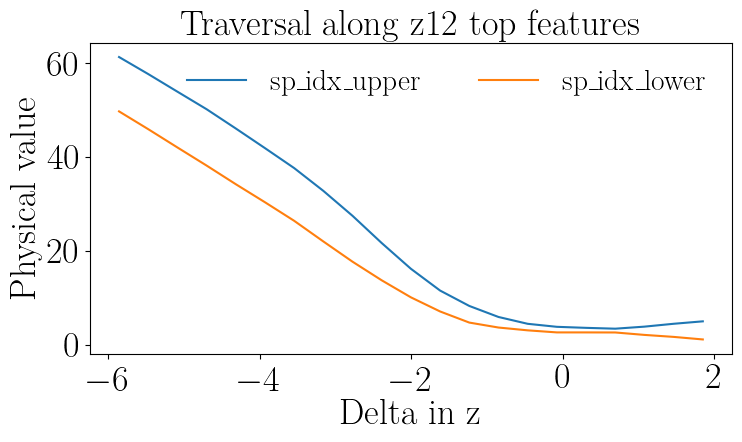

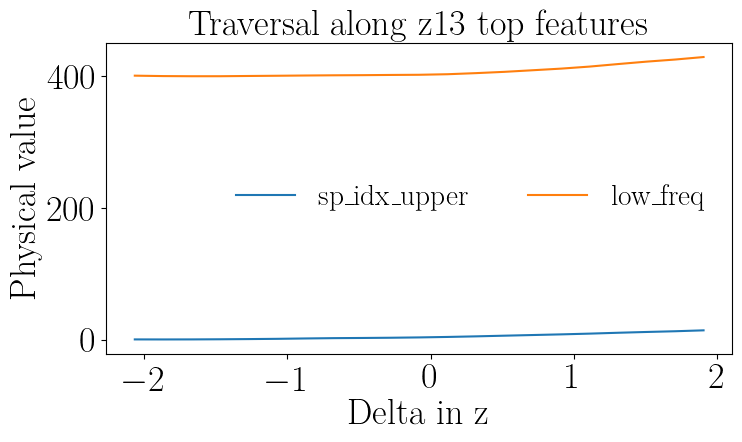

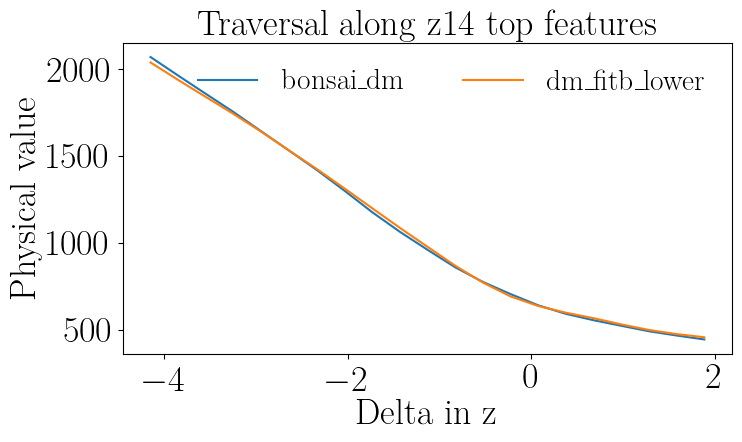

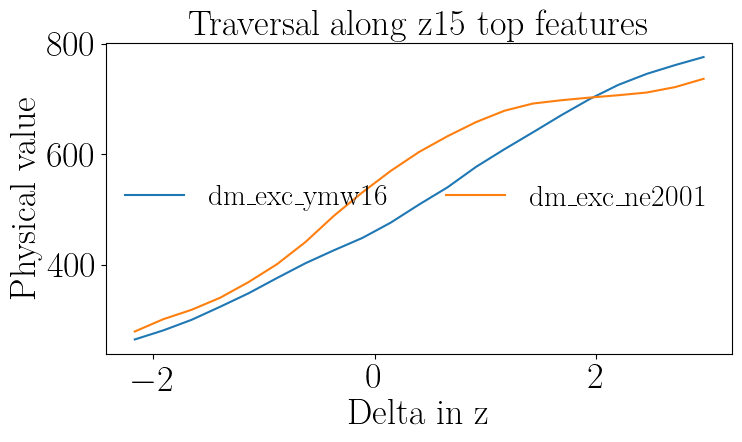

In [36]:
# reset plt config params


def traverse_one_dim(model, scaler, base_z, dim_idx, steps=np.linspace(-3, 3, 21)):
    # returns DataFrame of decoded physical features across steps
    model.eval()
    out = []
    with torch.no_grad():
        for s in steps:
            z = base_z.clone()
            z[0, dim_idx] = s
            x_hat = model.decode(z).cpu().numpy()          # standardized space
            x_phys = scaler.inverse_transform(x_hat)[0]     # physical units
            row = {"step": float(s)}
            for f, v in zip(new_features, x_phys):
                row[f] = v
            out.append(row)
    return pd.DataFrame(out)

def plot_traversal(df_trav, features, title, xlabel="Delta in z", ylabel="Physical value"):
    plt.figure(figsize=(8, 5))
    for f in features:
        plt.plot(df_trav["step"], df_trav[f], label=f)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(frameon=False, ncol=2)
    plt.tight_layout()
    plt.show()

steps = np.linspace(-3, 3, 21)

z0_vec = np.median(full_data_latent, axis=0)
base_z = torch.tensor(z0_vec, dtype=torch.float32, device=device).unsqueeze(0)

dims_to_traverse = [f"z{i}" for i in range(16)]

# for each chosen dim, pick the top 3 features for that dim to visualize
for zi in dims_to_traverse:
    dim_idx = int(zi.replace("z",""))  
    ranked_feats = top_features_by_z[zi]
    
    latent_vals = np.asarray(full_latent)[:, dim_idx]
    min_val = float(np.nanmin(latent_vals))
    max_val = float(np.nanmax(latent_vals))
    
    if np.isclose(min_val, max_val):
        special_steps = np.linspace(min_val - 1.0, max_val + 1.0, 21)
    else:
        special_steps = np.linspace(min_val, max_val, 21)

    # reduce to distinct base families to avoid plotting both lower and upper
    focus = []
    focus.extend(ranked_feats[0:2])

    df_trav = traverse_one_dim(full_model, scaler, base_z, dim_idx, special_steps)
    title = f"Traversal along {zi}  top features"
    plot_traversal(df_trav, focus, title)


probability gradients to ensure not endpoints being similar

In [37]:
# 1) slope and curvature along a traversal
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def summarize_traversal(df_trav, feats):
    out = []
    x = df_trav["step"].values.reshape(-1,1)
    for f in feats:
        y = df_trav[f].values
        # linear slope
        lin = LinearRegression().fit(x, y)
        slope = float(lin.coef_[0])
        # simple curvature proxy via quadratic coefficient
        quad = make_pipeline(PolynomialFeatures(2, include_bias=False), LinearRegression()).fit(x, y)
        a2 = float(quad.named_steps["linearregression"].coef_[1])  # coeff on step^2
        out.append({"feature": f, "slope_per_delta_z": slope, "curvature_quadratic": a2})
    return pd.DataFrame(out).sort_values("feature")


summaries = {}
for zi in dims_to_traverse:
    dim_idx = int(zi.replace("z",""))
    ranked_feats = top_features_by_z[zi]
    focus = []
    focus.extend(ranked_feats[0:2])

    # recompute traversal for this latent
    df_trav_i = traverse_one_dim(full_model, scaler, base_z, dim_idx, steps=steps)
    summaries[zi] = summarize_traversal(df_trav_i, focus)
    print(f"{zi} summary:")
    display(summaries[zi])

z0 summary:


,feature,slope_per_delta_z,curvature_quadratic
0,sp_run_lower,7.132804,0.151880
1,sp_run_upper,4.806345,0.065395


z1 summary:


,feature,slope_per_delta_z,curvature_quadratic
0,bonsai_dm,46.765942,-7.015855
1,dm_fitb_lower,53.090933,-4.568722


z2 summary:


,feature,slope_per_delta_z,curvature_quadratic
1,bonsai_dm,32.017713,-1.699148
0,dm_fitb_upper,32.854907,-8.114654


z3 summary:


,feature,slope_per_delta_z,curvature_quadratic
0,sp_idx_upper,1.537776,0.139768
1,sp_run_lower,-4.875100,1.304191


z4 summary:


,feature,slope_per_delta_z,curvature_quadratic
0,bonsai_dm,28.220168,-5.192677
1,dm_fitb_upper,23.677676,-8.888890


z5 summary:


,feature,slope_per_delta_z,curvature_quadratic
1,low_freq,0.143330,0.073351
0,peak_freq,12.209593,2.920842


z6 summary:


,feature,slope_per_delta_z,curvature_quadratic
0,high_freq,-8.245552,-0.897603
1,sp_run_lower,-3.312146,1.484394


z7 summary:


,feature,slope_per_delta_z,curvature_quadratic
0,sp_idx_lower,-0.308283,-0.046431
1,sp_idx_upper,-0.736740,0.255568


z8 summary:


,feature,slope_per_delta_z,curvature_quadratic
1,dm_exc_ymw16,44.237896,2.146667
0,sp_run_lower,3.386945,1.386674


z9 summary:


,feature,slope_per_delta_z,curvature_quadratic
0,low_freq,-4.098055,0.814955
1,sp_idx_upper,-3.057439,0.631681


z10 summary:


,feature,slope_per_delta_z,curvature_quadratic
0,fluence_lower,0.154769,-0.109605
1,fluence_upper,0.104237,-0.231898


z11 summary:


,feature,slope_per_delta_z,curvature_quadratic
1,dm_fitb_upper,-51.785683,-3.849367
0,high_freq,-34.307848,-4.608439


z12 summary:


,feature,slope_per_delta_z,curvature_quadratic
1,sp_idx_lower,-2.713581,0.797519
0,sp_idx_upper,-3.324548,1.641408


z13 summary:


,feature,slope_per_delta_z,curvature_quadratic
1,low_freq,7.985202,2.913872
0,sp_idx_upper,3.698040,0.993758


z14 summary:


,feature,slope_per_delta_z,curvature_quadratic
0,bonsai_dm,-212.504033,41.328536
1,dm_fitb_lower,-211.628301,41.510917


z15 summary:


,feature,slope_per_delta_z,curvature_quadratic
1,dm_exc_ne2001,97.904728,-7.301699
0,dm_exc_ymw16,101.125238,4.273966


In [38]:
def class_vs_step(model, base_z, dim_idx, steps):
    rows = []
    with torch.no_grad():
        for s in [min(steps), max(steps)]:
            z = base_z.clone()
            z[0, dim_idx] = s
            logit = model.classifier(z)
            prob = torch.sigmoid(logit).cpu().numpy().ravel()[0]
            rows.append({"step": float(s), "prob": float(prob)})
    return pd.DataFrame(rows)

d_probs = {}

for zi in dims_to_traverse:
    d = int(zi.replace("z",""))
    
    latent_vals = np.asarray(full_latent)[:, d]
    min_val = float(np.nanmin(latent_vals))
    max_val = float(np.nanmax(latent_vals))
    
    if np.isclose(min_val, max_val):
        special_steps = np.linspace(min_val - 1.0, max_val + 1.0, 21)
    else:
        special_steps = np.linspace(min_val, max_val, 21)

    
    dfp = class_vs_step(full_model, base_z, d, special_steps)
    print(zi, "Δprob across range:", dfp["prob"].iloc[-1] - dfp["prob"].iloc[0])
    delta_prob = dfp["prob"].iloc[-1] - dfp["prob"].iloc[0]
    d_probs[zi] = delta_prob

top_changes = sorted(d_probs.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
top_changes

z0 Δprob across range: -0.025079438695684075
z1 Δprob across range: -0.011392074629839044
z2 Δprob across range: 0.010420671438623685
z3 Δprob across range: 0.017407856765203178
z4 Δprob across range: 0.0029878513887524605
z5 Δprob across range: -0.004667945671826601
z6 Δprob across range: 0.009070153813809156
z7 Δprob across range: 0.0022984882816672325
z8 Δprob across range: -0.006750602973625064
z9 Δprob across range: -0.05880441528279334
z10 Δprob across range: -0.007167274714447558
z11 Δprob across range: -0.002461768686771393
z12 Δprob across range: -0.03382495976984501
z13 Δprob across range: 0.018199442652985454
z14 Δprob across range: -0.003218269208446145
z15 Δprob across range: -0.11072748026344925


[('z15', np.float64(-0.11072748026344925)),
 ('z9', np.float64(-0.05880441528279334)),
 ('z12', np.float64(-0.03382495976984501)),
 ('z0', np.float64(-0.025079438695684075)),
 ('z13', np.float64(0.018199442652985454))]

The Fisher information matrix is a way of measuring the amount of information that an observable random variable $X$ carries about an unknown parameter $\theta$ upon which the probability of $X$ depends.

Let $f(X; \theta)$ be the probability density function for $X$ given $\theta$. The Fisher information matrix is defined as:

$$\mathcal{I}(\theta)= E \left[ \left(\frac{\partial}{\partial \theta} \log f(X; \theta )\right)^2 \mid \theta \right]$$

For a Bernoulli distribution with $X \in (0, 1)$ and parameter $\theta$, we can find that the information matrix is

$$\frac{1}{\theta(1-\theta)}$$

Now, what if $\theta$ is some function of another variable, which we'll call $x$?. We can use the reparametrization rule 

$$\mathcal{I}(x)= \mathcal{I}_\theta(\theta(x)) \cdot \left(\frac{\partial\theta}{\partial x}\right)^2 $$

Now, assuming that our neural network is a modified Bernoulli distribution, with parameters $\theta(x)$ and where $x$ is a vector, we can write

$$\mathcal{I}(x) = \frac{1}{\theta(x)(1-\theta(x))} \left(\frac{\partial\theta}{\partial x}\right) \left(\frac{\partial\theta}{\partial x}\right)^\top$$

plug latent space origin and/or median into decoder, get vector, use that as input to fisher information matrix

In [39]:

def fisher_information_batch(model, xb, device, eps=1e-8):
    model.eval()
    x = xb.detach().to(device=device, dtype=torch.float32).requires_grad_(True)

    _, _, _, logits = model(x)
    p = torch.sigmoid(logits).squeeze(-1)                    # [B]

    B, D = x.shape
    grads = []
    for i in range(B):
        # grad of scalar p[i] wrt the whole batch x has shape [B, D]
        gi_full = torch.autograd.grad(p[i], x, retain_graph=True, create_graph=False)[0]
        gi = gi_full[i]                                      # [D]
        grads.append(gi)
    g = torch.stack(grads, dim=0)                            # [B, D]

    scale = 1.0 / (p * (1.0 - p) + eps)                      # [B]
    outer = g.unsqueeze(2) * g.unsqueeze(1)    # [B, D, D]
    F_batch = outer * scale.view(-1, 1, 1)     # scale each sample
    F_reduced = F_batch.mean(dim=0).float()                          # [D, D]

    return F_reduced


single_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
xb, _ = next(iter(single_loader))

F_avg_batch = fisher_information_batch(
    full_model, xb, device
)

print("Per-sample Fisher shape:", F_avg_batch.shape) 

Per-sample Fisher shape: torch.Size([17, 17])


In [40]:
# compute Fisher info for the whole dataset in batches

full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)
F_list = []
for xb, _ in full_loader:
    F_b = fisher_information_batch(full_model, xb, device)  # [D, D]
    F_list.append(F_b.cpu().detach().numpy())

F_full = np.mean(F_list, axis=0)
F_df = pd.DataFrame(F_full, index=new_features, columns=new_features)
F_df

,dm_fitb_lower,fluence_lower,flux_lower,sp_idx_lower,sp_run_lower,dm_fitb_upper,fluence_upper,flux_upper,sp_idx_upper,sp_run_upper,bonsai_dm,dm_exc_ne2001,dm_exc_ymw16,bc_width,high_freq,low_freq,peak_freq
dm_fitb_lower,0.031459,0.000856,0.008483,-0.009707,-0.036820,0.026831,-0.006205,0.005273,0.014251,0.021888,0.020407,-0.000469,-0.022249,0.007162,-0.010761,0.013709,0.004565
fluence_lower,0.000856,0.095213,-0.086186,0.029506,-0.025687,-0.007031,0.027048,-0.128819,0.069668,0.074206,0.011030,0.016650,-0.129795,-0.009263,0.014646,-0.051895,0.008912
flux_lower,0.008483,-0.086186,0.138639,-0.063956,0.019586,0.009225,-0.043316,0.111298,-0.069795,-0.067046,-0.002860,-0.030570,0.103512,0.004107,-0.052199,0.097554,-0.019903
sp_idx_lower,-0.009707,0.029506,-0.063956,0.092881,-0.016434,-0.001274,0.011180,-0.055213,0.049138,0.017114,-0.005040,0.032539,-0.059479,0.006098,0.037231,-0.039674,0.004441
sp_run_lower,-0.036820,-0.025687,0.019586,-0.016434,0.100556,-0.038291,0.005362,0.058642,-0.080812,-0.080394,-0.026472,-0.002901,0.124918,-0.008362,0.012054,0.025668,-0.016892
dm_fitb_upper,0.026831,-0.007031,0.009225,-0.001274,-0.038291,0.032687,-0.006879,0.021921,0.008098,0.010721,0.016808,0.001758,-0.009942,0.008982,-0.007259,0.007887,0.003646
fluence_upper,-0.006205,0.027048,-0.043316,0.011180,0.005362,-0.006879,0.030040,-0.013670,0.005379,0.011904,-0.006891,0.001890,-0.010220,-0.002038,0.019824,-0.024541,0.008100
flux_upper,0.005273,-0.128819,0.111298,-0.055213,0.058642,0.021921,-0.013670,0.282557,-0.163154,-0.152606,-0.022700,-0.036596,0.259276,0.024919,0.008583,0.092873,-0.005280
sp_idx_upper,0.014251,0.069668,-0.069795,0.049138,-0.080812,0.008098,0.005379,-0.163154,0.146896,0.118137,0.026752,0.024750,-0.200602,-0.007736,-0.023399,-0.068839,0.007054
sp_run_upper,0.021888,0.074206,-0.067046,0.017114,-0.080394,0.010721,0.011904,-0.152606,0.118137,0.134186,0.025189,0.009382,-0.182583,-0.006579,-0.008776,-0.059311,0.018099


In [41]:
# Eigenvalues of F_full
eigenvals, eigenvecs = np.linalg.eigh(F_full)

order = np.argsort(eigenvals)[::-1]
eigenvals = eigenvals[order]
eigenvecs = eigenvecs[:, order]

print("Top 10 eigenvalues:", eigenvals[:10])

Top 10 eigenvalues: [1.0104817  0.26118124 0.13797763 0.08535797 0.06101352 0.04756898
 0.03762119 0.02081055 0.012254   0.00999446]


In [42]:
eigvecs_df = pd.DataFrame(eigenvecs, index=new_features,
                          columns=[f"v{i+1}" for i in range(eigenvecs.shape[1])]).T

eigen_df = eigvecs_df.copy()
eigen_df["eigenvalue"] = eigenvals
#make eigenvals the first column
eigen_df = eigen_df[["eigenvalue"] + [col for col in eigen_df.columns if col != "eigenvalue"]]
eigen_df

,eigenvalue,dm_fitb_lower,fluence_lower,flux_lower,sp_idx_lower,sp_run_lower,dm_fitb_upper,fluence_upper,flux_upper,sp_idx_upper,sp_run_upper,bonsai_dm,dm_exc_ne2001,dm_exc_ymw16,bc_width,high_freq,low_freq,peak_freq
v1,1.010482,0.024597,0.247773,-0.246593,0.129291,-0.190962,0.004277,0.041372,-0.484065,0.351303,0.325440,0.059511,0.066799,-0.554034,-0.025921,-0.007886,-0.204723,0.032183
v2,0.261181,0.204705,-0.165633,0.485286,-0.286056,-0.295573,0.170116,-0.204645,0.057648,0.133516,0.141563,0.162412,-0.104725,-0.263542,0.010488,-0.427433,0.343625,-0.079195
v3,0.137978,0.270774,-0.117136,-0.175686,0.216017,-0.506704,0.361237,0.046255,0.479604,0.063385,0.104880,0.082716,0.013720,0.013754,0.190098,0.292921,-0.138117,0.229734
v4,0.085358,0.094418,0.224095,-0.135316,-0.728159,-0.024931,-0.010738,0.211200,0.022304,-0.202991,0.331098,0.022662,-0.299901,0.116390,-0.064708,0.069078,-0.190130,0.215779
v5,0.061014,-0.139860,-0.391502,-0.002318,-0.105248,-0.031167,-0.018357,-0.092820,0.071761,0.315104,0.010339,0.040716,0.049542,0.216326,-0.099056,-0.355825,-0.706988,-0.120195
v6,0.047569,0.250356,0.346978,-0.372647,-0.049492,0.140156,0.251711,0.192812,0.167141,-0.029547,-0.174052,0.377122,0.267186,0.062304,-0.022989,-0.394357,0.050305,-0.346790
v7,0.037621,-0.277527,0.065276,-0.074833,0.018178,0.015506,-0.183072,0.307751,0.513562,0.017476,-0.192146,-0.268953,-0.292148,-0.526846,-0.008887,-0.208001,-0.045341,-0.051935
v8,0.020811,0.041968,-0.151409,-0.093087,0.180749,0.154886,-0.147613,0.430372,0.085852,0.430888,0.484444,-0.099664,-0.079797,0.328677,0.008260,-0.150375,0.357513,0.020803
v9,0.012254,0.089804,-0.275111,-0.213726,-0.210256,0.416349,-0.203429,-0.217511,0.197113,0.143711,-0.020329,0.248159,0.326995,-0.277102,0.087793,0.030655,0.107415,0.488798
v10,0.009994,-0.009671,-0.345068,-0.232004,0.012425,0.130726,-0.046607,-0.207823,0.113313,-0.354789,0.473352,0.044987,-0.035280,-0.198526,0.056697,0.176000,0.014637,-0.569683


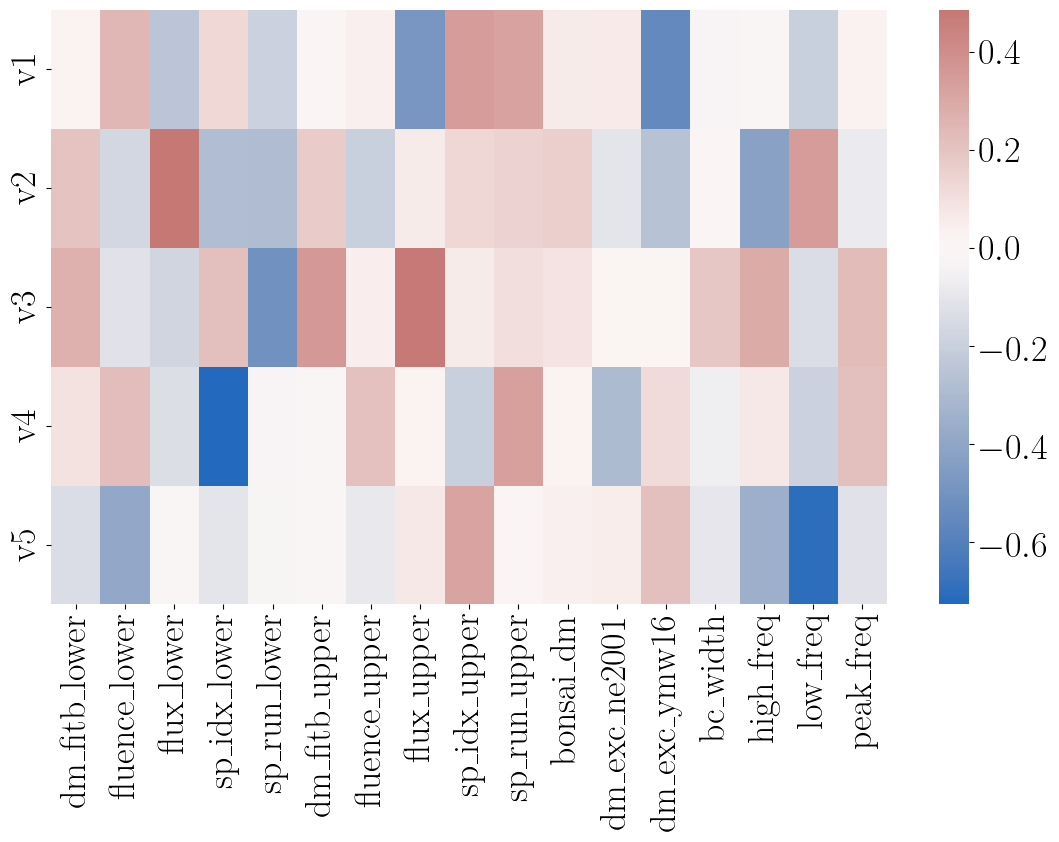

In [43]:
top_eigen_df = eigen_df.head(5).drop(columns=["eigenvalue"])

# make heatmap of top 5 eigenvectors
plt.figure(figsize=(global_figsize[0]*1.5, global_figsize[1]*1.5))
sns.heatmap(top_eigen_df.set_index(top_eigen_df.index.astype(str)), cmap="vlag", center=0)
plt.tight_layout()
plt.subplots_adjust(right=0.75)

plt.savefig("figs/full_dataset/Top5_Fisher_eigenvectors.svg",
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)

In [ ]:
for row in top_eigen_df.itertuples():
    vec = np.array(row[2:])
    top_indices = np.argsort(np.abs(vec))[::-1][:3]
    top_features = [(new_features[i], vec[i]) for i in top_indices]
    print(f"{row.Index}: " + ", ".join(f"{f} ({v:.3f})" for f, v in top_features))

v1: dm_exc_ne2001 (-0.554), fluence_upper (-0.484), flux_upper (0.351)
v2: fluence_lower (0.485), bc_width (-0.427), high_freq (0.344)
v3: sp_idx_lower (-0.507), fluence_upper (0.480), sp_run_lower (0.361)
v4: flux_lower (-0.728), sp_idx_upper (0.331), bonsai_dm (-0.300)
v5: high_freq (-0.707), dm_fitb_lower (-0.392), bc_width (-0.356)


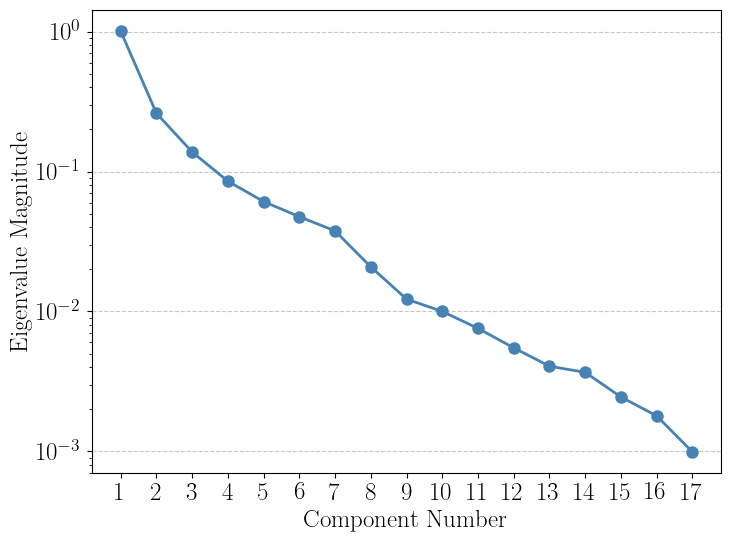

In [47]:


plt.figure(figsize=(global_figsize))
component_numbers = np.arange(len(eigenvals)) + 1

# Plot the eigenvalues
plt.plot(component_numbers, eigenvals, 'o-', linewidth=2, color='steelblue', markersize=8)

# Add labels and title
plt.xlabel('Component Number', fontsize=18)
plt.ylabel('Eigenvalue Magnitude', fontsize=18)
plt.yscale('log')

plt.xticks(component_numbers, fontsize=18)
plt.yticks(fontsize=18)


plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.subplots_adjust(right=0.75)

plt.savefig('figs/fisher_eigenvalues.svg', dpi=200, format='svg', bbox_inches='tight', pad_inches=0.1)

plt.show()




In [46]:
# Compare DM distributions between repeaters and non-repeaters
dm_features = ['bonsai_dm', 'dm_exc_ne2001', 'dm_exc_ymw16']

for dm_feat in dm_features:
    repeaters = frb_data[frb_data['repeater'] == 1][dm_feat]
    non_repeaters = frb_data[frb_data['repeater'] == 0][dm_feat]
    
    print(f"\n{dm_feat} Statistics:")
    print(f"Repeaters: mean={repeaters.mean():.2f}, std={repeaters.std():.2f}")
    print(f"Non-repeaters: mean={non_repeaters.mean():.2f}, std={non_repeaters.std():.2f}")


bonsai_dm Statistics:
Repeaters: mean=374.80, std=213.83
Non-repeaters: mean=675.13, std=435.34

dm_exc_ne2001 Statistics:
Repeaters: mean=257.29, std=229.95
Non-repeaters: mean=606.08, std=437.42

dm_exc_ymw16 Statistics:
Repeaters: mean=205.44, std=258.25
Non-repeaters: mean=601.64, std=438.74
